In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip "/content/drive/MyDrive/Leiden Uni/Audio Processing/release_in_the_wild (1).zip"

Streaming output truncated to the last 5000 lines.
  inflating: release_in_the_wild/550.wav  
  inflating: release_in_the_wild/5500.wav  
  inflating: release_in_the_wild/5501.wav  
  inflating: release_in_the_wild/5502.wav  
  inflating: release_in_the_wild/5503.wav  
  inflating: release_in_the_wild/5504.wav  
  inflating: release_in_the_wild/5505.wav  
  inflating: release_in_the_wild/5506.wav  
  inflating: release_in_the_wild/5507.wav  
  inflating: release_in_the_wild/5508.wav  
  inflating: release_in_the_wild/5509.wav  
  inflating: release_in_the_wild/551.wav  
  inflating: release_in_the_wild/5510.wav  
  inflating: release_in_the_wild/5511.wav  
  inflating: release_in_the_wild/5512.wav  
  inflating: release_in_the_wild/5513.wav  
  inflating: release_in_the_wild/5514.wav  
  inflating: release_in_the_wild/5515.wav  
  inflating: release_in_the_wild/5516.wav  
  inflating: release_in_the_wild/5517.wav  
  inflating: release_in_the_wild/5518.wav  
  inflating: release_in_the

# Imports and hyperparameter configuration

In [9]:
import os
import librosa
import numpy as np
import pandas as pd
import tensorflow as tf
import joblib
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from google.colab import files
import shutil
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [10]:
# Paths to audio files and metadata
audio_folder = "/content/release_in_the_wild"
meta_path = "/content/release_in_the_wild/final_updated_meta.csv"

# Load metadata
meta_full = pd.read_csv(meta_path)
print(f"Loaded metadata with {len(meta_full)} entries.")

# Splitting the metadata
meta = meta_full.iloc[:19963]  # From index 0 to 19962
split2 = meta_full.iloc[19963:]  # From index 19963 to 24247

# Display the sizes of the splits
print(f"Split1 size: {len(meta)} entries.")
print(f"Split2 size: {len(split2)} entries.")

Loaded metadata with 20448 entries.
Split1 size: 19963 entries.
Split2 size: 485 entries.


In [11]:
# Hyperparameters configuration
n_mfcc = 13
n_mels = 128
max_frames = 300
sr = 16000
batch_size = 32
epochs = 20
random_seed = 42

# Feature extraction methods

In [12]:
def extract_mfcc_feature(audio_file, sr=16000, n_mfcc=13):
    """ This function extracts 2D MFCC features and returns a 2D array for each audio file."""
    try:
        y, sr = librosa.load(audio_file, sr=sr)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        mfccs = librosa.util.normalize(mfccs)
        mfccs = librosa.util.fix_length(mfccs, size=max_frames, axis=1)  # Pad/Truncate
        return mfccs
    except Exception as e:
        print(f"Error processing {audio_file}: {e}")
        return None

In [13]:
def extract_features(audio_file, sr=16000, n_mfcc=13):
    try:
        # Load audio file
        y, sr = librosa.load(audio_file, sr=sr)
        # Compute MFCCs
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        # Return the mean of the MFCCs over time
        return np.mean(mfccs, axis=1)
    except Exception as e:
        print(f"Error processing {audio_file}: {e}")
        return None

# Audio input normalization

The audio normalization consists of following steps:  
1. Removing outliers
2. Remove imbalanced classes

## Remove outliers from data folder and metadata file

In [14]:
def identify_outliers(durations, threshold=1.5):
    """
    Identifies outliers in audio durations using the IQR method.

    Parameters:
    - durations: List of durations (in seconds).
    - threshold: Multiplicative factor for IQR to determine outliers.

    Returns:
    - outliers: List of durations identified as outliers.
    """
    Q1 = np.percentile(durations, 25)
    Q3 = np.percentile(durations, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR

    outliers = [d for d in durations if d < lower_bound or d > upper_bound]
    return outliers


def remove_outliers(meta, column='duration', threshold=1.5):
    """
    Removes rows from the DataFrame where the values in the specified column are outliers.

    Parameters:
    - meta (pd.DataFrame): DataFrame containing the column to check for outliers.
    - column (str): Column name to check for outliers.
    - threshold (float): Threshold for IQR to determine outliers.

    Returns:
    - meta (pd.DataFrame): Updated DataFrame with outliers removed.
    """
    durations = meta[column].tolist()
    outliers = identify_outliers(durations, threshold=threshold)
    initial_count = len(meta)

    # Remove rows with outlier durations
    meta = meta[~meta[column].isin(outliers)].reset_index(drop=True)
    final_count = len(meta)
    removed = initial_count - final_count
    print(f"Removed {removed} outlier entries.")

    return meta

In [15]:
def calculate_durations(meta, audio_folder, sr=16000):
    """
    Calculates the duration of each audio file and adds it as a new column in the metadata DataFrame.

    Parameters:
    - meta (pd.DataFrame): DataFrame containing at least a 'file' column.
    - audio_folder (str): Path to the folder containing audio files.
    - sr (int): Sampling rate for loading audio files.

    Returns:
    - meta (pd.DataFrame): Updated DataFrame with a new 'duration' column.
    """
    durations = []
    for idx, row in tqdm(meta.iterrows(), total=len(meta), desc="Calculating Durations"):
        file_name = row['file']
        file_path = os.path.join(audio_folder, file_name)
        try:
            duration = librosa.get_duration(filename=file_path, sr=sr)
            durations.append(duration)
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            durations.append(None)  # Append None for failed files

    # Add durations to DataFrame
    meta['duration'] = durations

    # Optionally, remove entries with None durations
    initial_count = len(meta)
    meta = meta.dropna(subset=['duration']).reset_index(drop=True)
    final_count = len(meta)
    removed = initial_count - final_count
    if removed > 0:
        print(f"Removed {removed} entries due to failed duration calculations.")

    return meta

# Calculate durations
meta = calculate_durations(meta, audio_folder, sr=16000)
print(f"Metadata now contains 'duration' column.")

Calculating Durations:   0%|          | 0/19963 [00:00<?, ?it/s]<ipython-input-15-bfa2b559a955>:18: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=file_path, sr=sr)
Calculating Durations: 100%|██████████| 19963/19963 [27:15<00:00, 12.21it/s]
<ipython-input-15-bfa2b559a955>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta['duration'] = durations


Metadata now contains 'duration' column.


In [16]:
# Step 2: Remove outliers
meta = remove_outliers(meta, column='duration', threshold=1.5)
print("Outliers have been removed from the DataFrame.")

Removed 1155 outlier entries.
Outliers have been removed from the DataFrame.


## Remove imbalanced classes

In [17]:
def aggregate_audio_data_by_speaker(meta, duration_column='duration'):
    """
    Aggregates audio data to compute:
    - Total number of audio files per speaker.
    - Total duration of audio files per speaker.
    - Average duration per audio file for each speaker.

    Parameters:
    - meta (pd.DataFrame): DataFrame containing the data.
    - duration_column (str): Column name representing the audio duration.

    Returns:
    - aggregated_df (pd.DataFrame): Aggregated data with counts, total durations, and average durations per speaker.
    """
    aggregated_df = (
        meta.groupby('speaker')
        .agg(
            total_files=('file', 'count'),
            total_duration=(duration_column, 'sum'),
        )
        .reset_index()
    )

    # Add average duration per file
    aggregated_df['average_duration'] = (
        aggregated_df['total_duration'] / aggregated_df['total_files']
    )

    # Sort by total duration in descending order
    aggregated_df = aggregated_df.sort_values(by='total_duration', ascending=False).reset_index(drop=True)

    return aggregated_df


aggregate_audio_data_by_speaker(meta, duration_column='duration')

,speaker,total_files,total_duration,average_duration
0,Barack Obama,3098,11035.678000,3.562194
1,Donald Trump,3147,10230.536313,3.250885
2,Bernie Sanders,1513,5115.920687,3.381309
3,Alec Guinness,1818,4748.248312,2.611798
4,Ayn Rand,1356,4735.859875,3.492522
5,Bill Clinton,1117,3064.430750,2.743447
6,Christopher Hitchens,753,2610.130250,3.466308
7,Ronald Reagan,607,1902.231313,3.133824
8,Winston Churchill,623,1689.100062,2.711236
9,Martin Luther King,490,1364.259375,2.784203


### Randomly dropping tracks from extreme majority classes

In [18]:
drop_counts = {
    'Barack Obama': 2000,
    'Donald Trump': 2000,
    'Bernie Sanders': 500,
    'Alec Guinness': 800,
    'Ayn Rand': 300
}

# Loop through each speaker and drop the specified number of records
for speaker, drop_count in drop_counts.items():
    speaker_data = meta[meta['speaker'] == speaker]

    # Randomly sample the records to drop
    drop_indices = np.random.choice(speaker_data.index, size=drop_count, replace=False)

    # Drop the selected records from the DataFrame
    meta = meta.drop(drop_indices)

# Reset the index after dropping
meta.reset_index(drop=True, inplace=True)

print(f"After dropping, the dataset contains {len(meta)} records.")

After dropping, the dataset contains 13208 records.


### Fully dropping extreme minority classes

In [19]:
# Count the number of recordings per speaker
speaker_counts = meta['speaker'].value_counts()

# Get a list of speakers with fewer than 10 recordings
speakers_to_drop = speaker_counts[speaker_counts < 10].index

# Drop those speakers from the DataFrame
meta = meta[~meta['speaker'].isin(speakers_to_drop)]

# Reset index after dropping
meta.reset_index(drop=True, inplace=True)

print(f"After dropping, the dataset contains {len(meta)} records.")

After dropping, the dataset contains 13180 records.


In [20]:
aggregate_audio_data_by_speaker(meta, duration_column='duration')

,speaker,total_files,total_duration,average_duration
0,Barack Obama,1098,3934.892000,3.583690
1,Donald Trump,1147,3746.971062,3.266758
2,Ayn Rand,1056,3598.877437,3.408028
3,Bernie Sanders,1013,3414.305937,3.370490
4,Bill Clinton,1117,3064.430750,2.743447
5,Alec Guinness,1018,2676.037500,2.628721
6,Christopher Hitchens,753,2610.130250,3.466308
7,Ronald Reagan,607,1902.231313,3.133824
8,Winston Churchill,623,1689.100062,2.711236
9,Martin Luther King,490,1364.259375,2.784203


In [21]:
meta = pd.concat([meta, split2], ignore_index=True)

print(f"Loaded metadata with {len(meta)} entries.")
meta.to_csv("/content/processed_meta.csv", index=False)

Loaded metadata with 13665 entries.


# Classifier

In [22]:
def train_random_forest(features, labels):
  # Convert features and labels to arrays
  X = np.array(features)
  y = np.array(labels)
  print(X.shape)
  print(y.shape)

  # Train-test split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

  # Train a classifier
  clf = RandomForestClassifier(n_estimators=100, random_state=42)
  clf.fit(X_train, y_train)
  return clf, X_test, y_test

In [36]:
def get_predictions(clf, X_test, y_test):
  # Predict on the test set
  y_pred = clf.predict(X_test)

  # Evaluate the model
  accuracy = accuracy_score(y_test, y_pred)
  print(f"Accuracy: {accuracy:.2f}")
  print("Classification Report:")
  print(classification_report(y_test, y_pred))
  return y_pred

## MFCC Method A

In [24]:
features, labels = [], []
for _, row in meta.iterrows():
    file_path = os.path.join(audio_folder, row['file'])
    speaker = row['speaker']

    # Extract features
    feature = extract_features(file_path)
    if feature is not None:
        features.append(feature)
        labels.append(speaker)

In [25]:
# Train the classifier
clf_A, X_test_A, y_test_A = train_random_forest(features, labels)

(13665, 13)
(13665,)


In [37]:
# Predict on the test set
y_pred_A = get_predictions(clf_A, X_test_A, y_test_A)

# Save results
joblib.dump(clf_A, "./random_forest_A.joblib")

Accuracy: 0.92
Classification Report:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                          precision    recall  f1-score   support

                    2Pac       0.91      1.00      0.95        10
             Adam Driver       0.96      0.90      0.93        30
              Alan Watts       0.83      0.31      0.45        16
           Alec Guinness       0.88      0.95      0.91       210
Alexandria Ocasio-Cortez       0.96      0.96      0.96        51
   Arnold Schwarzenegger       0.85      0.87      0.86        45
                Ayn Rand       0.98      0.96      0.97       211
            Barack Obama       0.87      0.94      0.91       219
          Bernie Sanders       0.93      0.93      0.93       203
               Bill Burr       0.92      0.55      0.69        22
            Bill Clinton       0.90      0.97      0.94       245
                Bob Ross       0.78      0.70      0.74        10
           Boris Johnson       0.97      0.84      0.90        37
         Calvin Coolidge       1.00      1.00      1.00        11
    Chris

['./random_forest_A.joblib']

## MFCC Method B

In [27]:
# Perform feature extraction
features, labels = [], []
for _, row in tqdm(meta.iterrows(), total=len(meta), desc="Processing files"):
    file_path = os.path.join(audio_folder, row['file'])
    speaker = row['speaker']

    # Extract mfcc features
    feature = extract_mfcc_feature(file_path)

    if feature is not None:
        features.append(feature.flatten())
        labels.append(speaker)

Processing files: 100%|██████████| 13665/13665 [04:37<00:00, 49.26it/s]


In [28]:
# Train the classifier
clf_B, X_test_B, y_test_B = train_random_forest(features, labels)

(13665, 3900)
(13665,)


In [29]:
# Predict on the test set
y_pred_B = get_predictions(clf_B, X_test_B, y_test_B)

# Save results
joblib.dump(clf_B, "./random_forest_B.joblib")

Accuracy: 0.83
Classification Report:
                          precision    recall  f1-score   support

                    2Pac       1.00      1.00      1.00        10
             Adam Driver       0.84      0.53      0.65        30
              Alan Watts       1.00      0.31      0.48        16
           Alec Guinness       0.69      0.90      0.79       210
Alexandria Ocasio-Cortez       1.00      0.33      0.50        51
   Arnold Schwarzenegger       0.86      0.93      0.89        45
                Ayn Rand       0.74      0.97      0.84       211
            Barack Obama       0.71      0.88      0.79       219
          Bernie Sanders       0.82      0.94      0.88       203
               Bill Burr       0.86      0.27      0.41        22
            Bill Clinton       0.80      0.99      0.89       245
                Bob Ross       1.00      0.20      0.33        10
           Boris Johnson       0.88      0.19      0.31        37
         Calvin Coolidge       1.00  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


['./random_forest_B.joblib']

# PLot results

In [38]:
# Combine the true labels and predicted labels into a DataFrame for easy analysis
results_df = pd.DataFrame({'True_Label': y_test_A, 'Predicted_Label': y_pred_A})

# Identify correctly classified examples
correctly_classified = results_df[results_df['True_Label'] == results_df['Predicted_Label']]
print("Correctly Classified Examples:")
print(correctly_classified)

# Identify misclassified examples
misclassified = results_df[results_df['True_Label'] != results_df['Predicted_Label']]
print("\nMisclassified Examples:")
print(misclassified)

Correctly Classified Examples:
                True_Label       Predicted_Label
0            Ronald Reagan         Ronald Reagan
1     Christopher Hitchens  Christopher Hitchens
2            George Carlin         George Carlin
3     Christopher Hitchens  Christopher Hitchens
4        Winston Churchill     Winston Churchill
...                    ...                   ...
2728              Ayn Rand              Ayn Rand
2729          Donald Trump          Donald Trump
2730             Malcolm X             Malcolm X
2731                   JFK                   JFK
2732          Barack Obama          Barack Obama

[2505 rows x 2 columns]

Misclassified Examples:
                True_Label       Predicted_Label
5             Harry Truman         George Carlin
40         Mark Zuckerberg        Bernie Sanders
59      Scarlett Johansson         Ronald Reagan
64    Christopher Hitchens          Barack Obama
66           Jeff Goldblum          Donald Trump
...                    ...           

In [39]:
correct_count = len(correctly_classified)
incorrect_count = len(misclassified)

print(f"Correctly Classified: {correct_count}")
print(f"Incorrectly Classified: {incorrect_count}")

Correctly Classified: 2505
Incorrectly Classified: 228


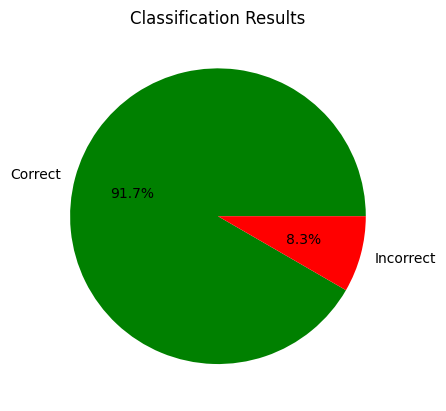

In [40]:
counts = [correct_count, incorrect_count]
labels = ['Correct', 'Incorrect']
colors = ['green', 'red']

plt.pie(counts, labels=labels, autopct='%1.1f%%', colors=colors)
plt.title("Classification Results")
plt.show()

In [30]:
def list_top_confused_classes(clf, X_test, y_test):
  # Predict on the test set using Random Forest
  y_pred = clf.predict(X_test)  # Directly gives class labels

  # Compute the confusion matrix
  cm = confusion_matrix(y_test, y_pred)

  # Create a DataFrame for better manipulation
  cm_df = pd.DataFrame(cm, index=np.unique(y_test), columns=np.unique(y_test))

  # Set the diagonal to zero to exclude correct predictions
  np.fill_diagonal(cm, 0)

  # Stack the confusion matrix to have a long-form DataFrame
  cm_stacked = cm_df.stack().reset_index()
  cm_stacked.columns = ['Actual', 'Predicted', 'Count']

  # Remove zero entries
  cm_stacked = cm_stacked[cm_stacked['Count'] > 0]

  # Sort by count descending
  cm_sorted = cm_stacked.sort_values(by='Count', ascending=False)

  # Display top N confused class pairs
  top_n = 20
  top_confusions = cm_sorted.head(top_n)


  print(f"Top {top_n} Confused Class Pairs:")
  print(top_confusions)
  return top_confusions

In [31]:
def plot_top_confused_classes(top_confusions, top_n):
  # Prepare data for heatmap
  top_confusions_matrix = top_confusions.pivot(index='Actual', columns='Predicted', values='Count').fillna(0)
  top_confusions_matrix = top_confusions_matrix.astype(int)

  # Create the annotated heatmap for top N confusions
  plt.figure(figsize=(14, 12))
  sns.heatmap(
      top_confusions_matrix,
      annot=True,
      fmt='d',
      cmap='Reds',
      linewidths=.5,
      linecolor='gray',
      cbar=True,
      annot_kws={"size": 12}
  )

  # Customize the plot
  plt.title(f'Top {top_n} Most Confused Class Pairs', fontsize=16)
  plt.ylabel('Actual Class', fontsize=14)
  plt.xlabel('Predicted Class', fontsize=14)
  plt.xticks(rotation=45, ha='right', fontsize=12)
  plt.yticks(rotation=0, fontsize=12)
  plt.tight_layout()

  # Display the heatmap
  plt.show()

## Method A

In [32]:
top_confusions_A = list_top_confused_classes(clf_A, X_test_A, y_test_A)

Top 20 Confused Class Pairs:
                     Actual              Predicted  Count
353            Barack Obama           Bill Clinton      7
399          Bernie Sanders           Barack Obama      7
1484        Louis Farrakhan   Christopher Hitchens      6
261   Arnold Schwarzenegger           Donald Trump      5
310                Ayn Rand           Donald Trump      4
716    Christopher Hitchens        Louis Farrakhan      4
455               Bill Burr   Christopher Hitchens      4
930                     FDR      Winston Churchill      3
395          Bernie Sanders          Alec Guinness      3
791            Donald Trump           Barack Obama      3
1241          Jeff Goldblum           Donald Trump      3
990           George Carlin           Bill Clinton      3
155           Alec Guinness         Bernie Sanders      3
1718        Milton Friedman          Alec Guinness      3
1869          Nick Offerman           Barack Obama      3
471               Bill Burr        Louis Fa

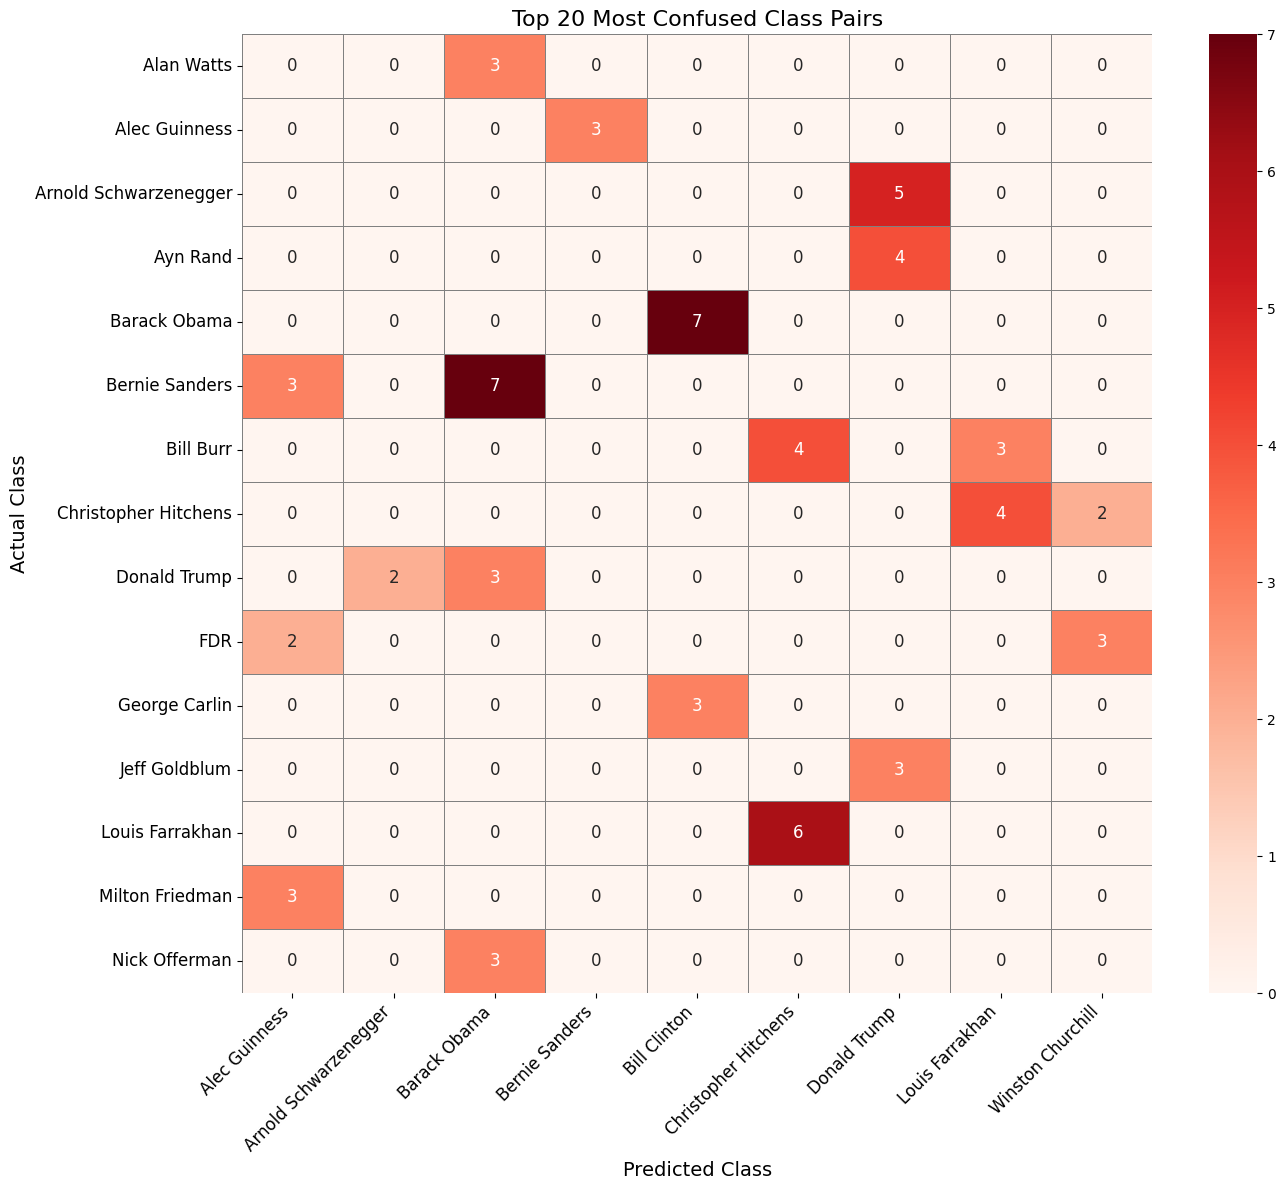

In [33]:
plot_top_confused_classes(top_confusions_A, 20)